In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [22]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
Session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
most_recent_date = Session.query(func.max(measurement.date)).all()
most_recent_date

[('2017-08-23',)]

<Axes: title={'center': 'Past Year Precipitation (Inches)'}, xlabel='Dates', ylabel='Precipitation (Inches)'>

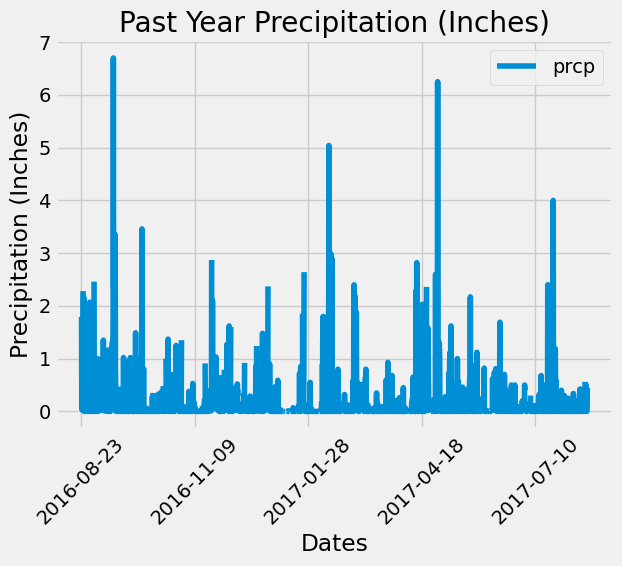

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
past_year_data = Session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(past_year_data, columns=['date', 'prcp'])

# Sorted df
sorted_df = df.sort_values('date')

# Rotate the x-axis labels for date
sorted_df.plot(x='date', y='prcp', rot=45, title='Past Year Precipitation (Inches)', 
               xlabel='Dates', ylabel='Precipitation (Inches)')

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations = Session.query(func.count(func.distinct(measurement.station))).scalar()
print(f"Total Amount of Stations: {total_stations}")

Total Amount of Stations: 9


In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = Session.query(measurement.station, 
   func.count(measurement.station)).group_by(measurement.station).\
      order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

# Create a subquery for temperature
subquery = Session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(
    measurement.station == most_active
).all()

lowest_temp, highest_temp, avg_temp = subquery[0]

# Print the output
print(f"Most Active Station: {most_active}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


<Axes: title={'center': 'USC00519281 Yearly Temp'}, xlabel='Temperature', ylabel='Frequency'>

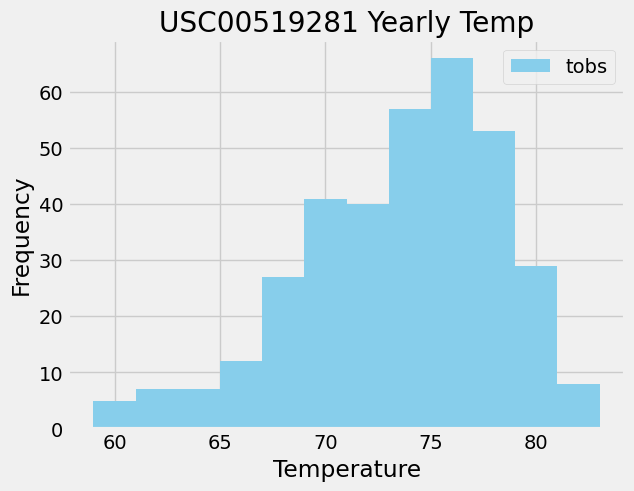

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# First find the most active id
most_active_station_id = active_stations[0][0]

# Get all the data for temp in the past year
past_year_data = Session.query(measurement.date, measurement.tobs).filter(measurement.date >= prev_year).all()

# Temp based on USC00519281
temperature_data = Session.query(measurement.tobs).filter(
    measurement.station == most_active_station_id,
    measurement.date >= prev_year).all()

# Create a DataFrame from the query result
temp_df = pd.DataFrame(temperature_data, columns=['tobs'])

temp_df.plot.hist(bins=12, color='skyblue', legend='tobs', xlabel="Temperature", title="USC00519281 Yearly Temp")

# Close Session

In [33]:
# Close Session
Session.close()